<a href="https://colab.research.google.com/github/i2mmmmm/Study/blob/main/Pytorch/%EB%B3%B5%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###복습
1. 간단한 선형회귀모델 (y=2x+1)
2. 평균제곱오차 손실함수 (회귀에서 일반적으로 쓰는 실제값과 예측값 사이의 제곱을 최소화하는 함수)
3. 확률적 경사하강법(SGD) 사용 최적화 설정
4. 1000번 에포크동안 모델 학습
5. 학습된 모델로 새로운 데이터 예측, 출력

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim

# 간단한 데이터셋 생성
x_data = torch.rand((100,1))*10
y_data = 2 * x_data + 1 + torch.randn((100,1))

# 모델 정의
class SimpleLinearRegression(nn.Module):
  def __init__(self):
    super(SimpleLinearRegression, self).__init__()
    self.linear = nn.Linear(1,1)

  def forward(self,x):
    return self.linear(x)

# 모델, 손실함수, 옵티마이저 세팅
model = SimpleLinearRegression()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# 학습
for epoch in range(1000):
  # 순전파
  y_pred  = model(x_data)
  # 손실계산
  loss = criterion (y_pred, y_data)

  # 역전파, 옵티마이저로 모델 가중치 업데이트
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # 100번의 에포크마다 손실 출력
  if (epoch+1)%100 == 0:
    print(f'Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}')

# 학습된 모델을 사용하여 예측
with torch.no_grad():
  new_x = torch.tensor([[5.0]])
  prediction = model(new_x)
  print(f'Prediction after training: {prediction.item():.4f}')

Epoch [100/1000], Loss: 1.0939
Epoch [200/1000], Loss: 1.0938
Epoch [300/1000], Loss: 1.0937
Epoch [400/1000], Loss: 1.0937
Epoch [500/1000], Loss: 1.0936
Epoch [600/1000], Loss: 1.0936
Epoch [700/1000], Loss: 1.0936
Epoch [800/1000], Loss: 1.0936
Epoch [900/1000], Loss: 1.0936
Epoch [1000/1000], Loss: 1.0936
Prediction after training: 11.0949


##CNN

###합성곱층(Convolutional Layer)
- 필터(커널)을 사용하여 입력 이미지에 대해 합성곱 연산을 수행
- 이를 통해 이미지에서 특징이나 패턴을 감지하고 추출

###풀링층(Pooling Layer)
- 공간 차원을 줄이기 위해 사용
- 일반적으로 최대 풀링(Max Pooling)이나 평균 풀링(Average Pooling)이 사용

###완전연결층(Fully connected Layer)
- 최종적인 분류 수행
- 이전 합성곱과 풀링을 통해 추출된 특징을 이용해 입력 데이터를 분류


In [5]:
# 주어진 이미지를 10개의 클래스로 분류하는 작업

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


#GPU 사용 가능하다면 GPU, 그렇지 않다면 CPU 사용

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리, 로딩
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(3,16,kernel_size=3, stride=1, padding=1)
    # 2D 합성곱 레이어 (입력 채널수, 출력 채널수, 커널(필터)크기, 스트라이드, 패딩)
    # 컬러 이미지 = RGD 채널이라서 입력 채널 = 3
    # 스트라이드는 건너뛰면서 이동, (1,28,28) 이미지를 stride =2 로 하면 (1,14,14)로 출력
    # 이미지의 가장자리 정보를 보존하려고 패딩을 넣음

    self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
    # 2D 최대 풀링 레이어
    self.conv2 = nn.Conv2d(16,32,kernel_size=3, stride=1, padding=1)
    self.fc = nn.Linear(32*8*8,10)
    # 선형 레이어, fully connected (입력 특징 수, 출력 특징 수)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,32*8*8)
    # 텐서 평탄화 3d 텐서를 1d로 변환하는 역할
    x = self.fc(x)
    return x

# 모델, 손실함수, 옵티마이저
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

# 에포크 수만큼 반복
for epoch in range (3):
  model.train()

  # 미니배치 단위로 데이터를 가져와 학습
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    # 순전파
    outputs = model(inputs)

    # 손실 계산
    loss = criterion(outputs, targets)

    # 그래디언트 초기화 및 역전파
    optimizer.zero_grad()
    loss.backward()

    # 가중치 업데이트
    optimizer.step()

  #현재 에포크에서의 손실 출력
  print(f'Epoch [{epoch+1}/3], Loss: {loss.item():.4f}')


Files already downloaded and verified
Epoch [1/3], Loss: 1.9861
Epoch [2/3], Loss: 1.3305
Epoch [3/3], Loss: 1.4090


In [8]:
# 테스트 데이터를 로드하는 DataLoader 생성
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


# 평가 코드
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Accuracy on the test set: {:.2%}'.format(accuracy))

Files already downloaded and verified
Accuracy on the test set: 51.35%


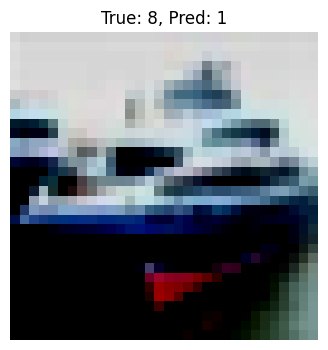

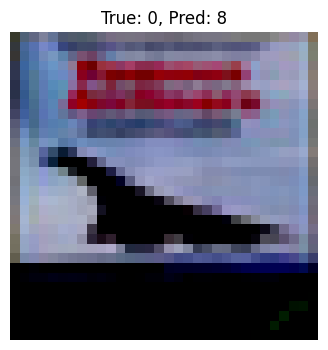

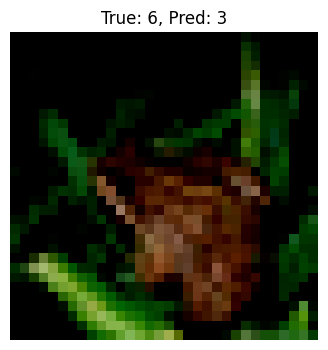

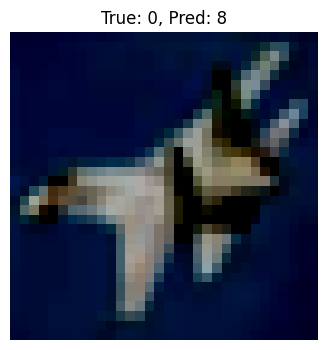

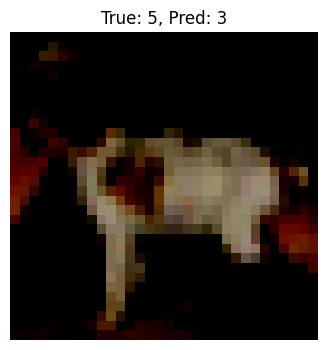

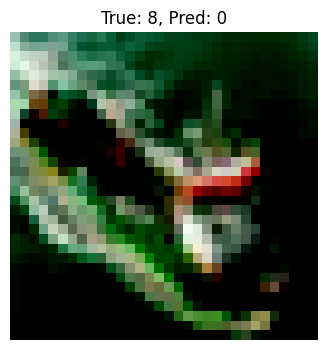

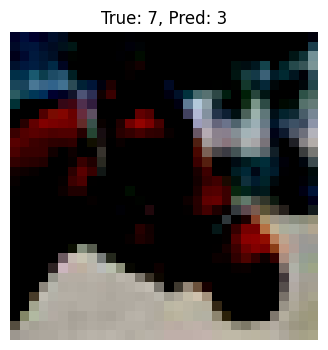

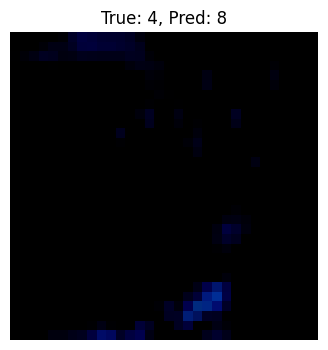

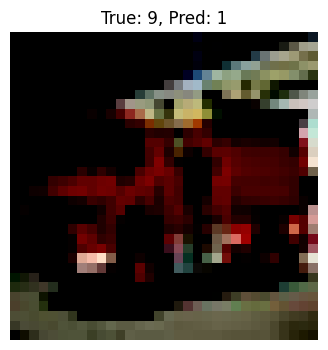

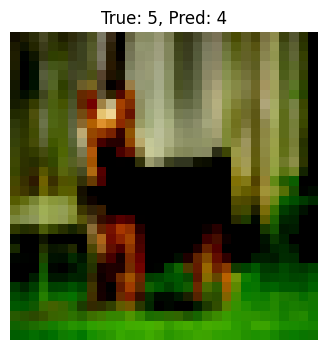

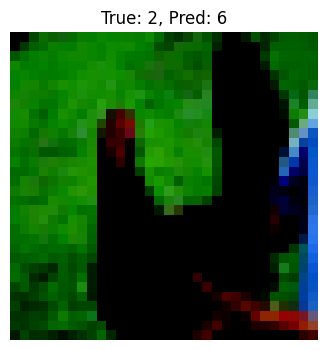

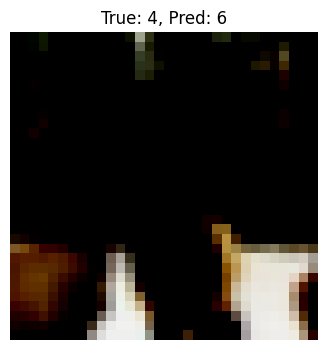

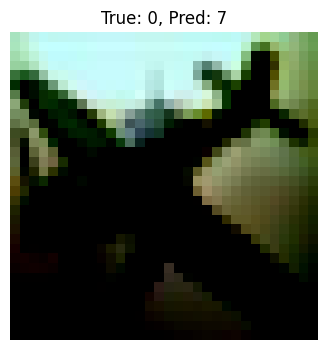

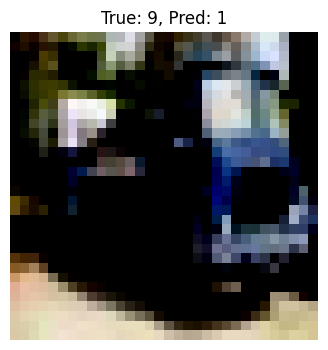

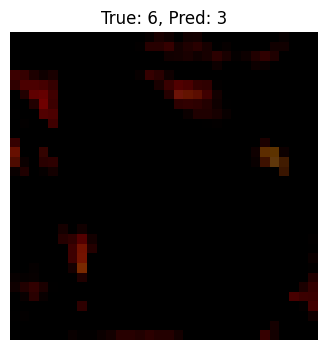

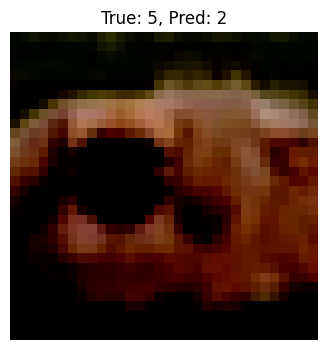

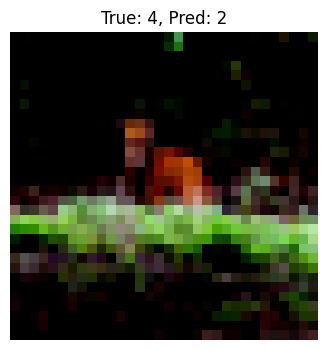

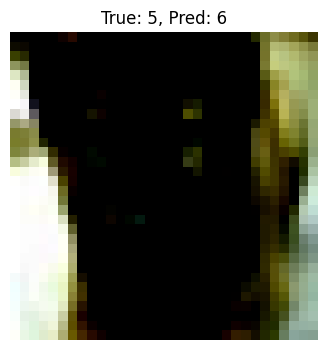

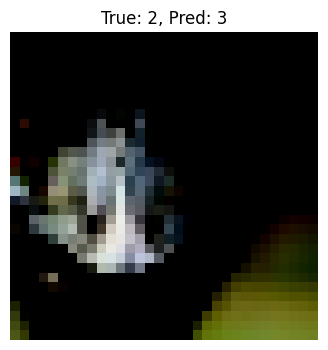

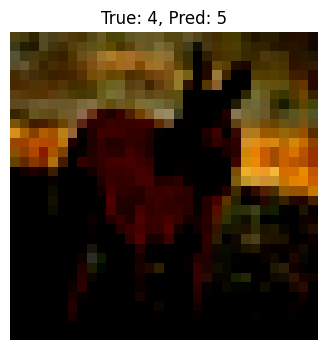

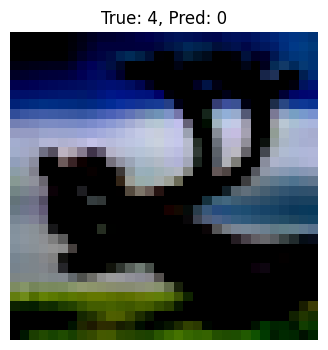

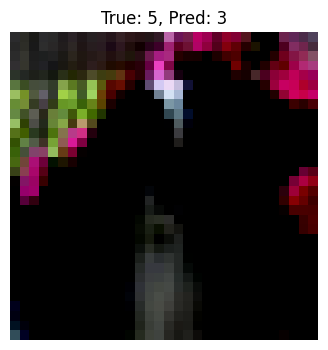

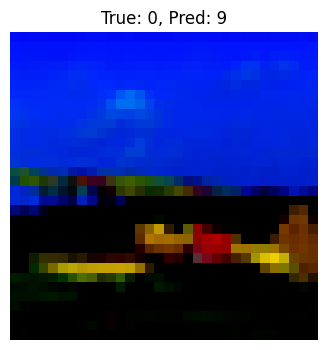

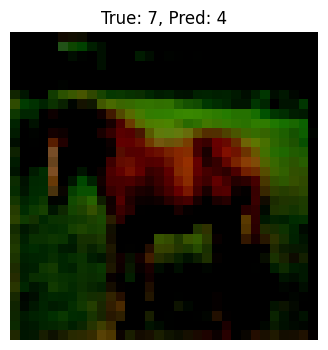

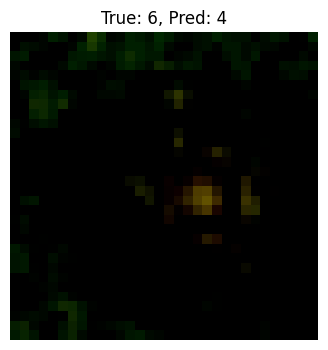

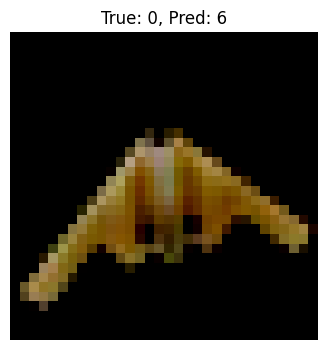

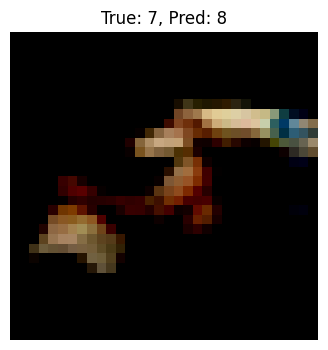

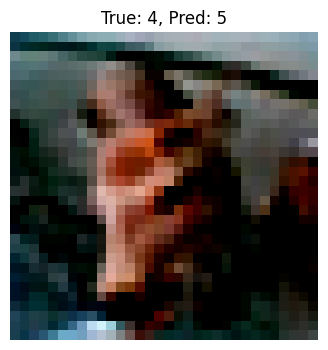

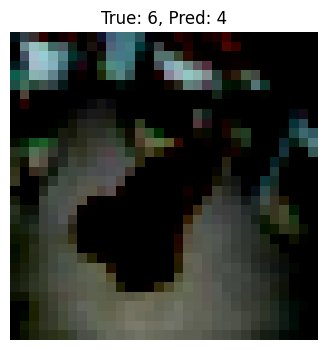

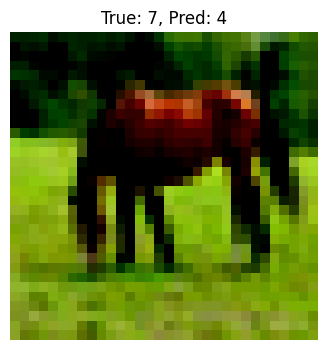

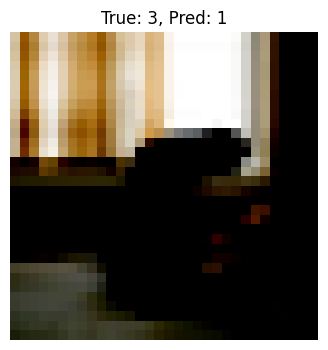

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 평가
model.eval()

# 틀린 예측 확인
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        incorrect_samples = (predicted != labels).nonzero()[:, 0]
        break  # 첫 번째 배치만 확인

# 틀린 예측 시각화
for index in incorrect_samples:
    image, label, prediction = images[index].cpu().numpy().transpose((1, 2, 0)), labels[index].item(), predicted[index].item()

    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f'True: {label}, Pred: {prediction}')
    plt.axis('off')
    plt.show()